# Transforming Series

In [7]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from scipy.stats import gumbel_r, lognorm, cauchy
import yfinance as yf

### Gumbel

Expected Value: $E(X)=\mu+\beta\gamma$ where $\gamma$ is Euler-Mascheroni constant

Median Value: $q^{0.5}_X = \mu - \beta \ln(\ln(2))$

Difference: $E(X)-q^{0.5}_X = \beta (\gamma+\ln(\ln(2))) \approx \beta \times 0.210703$

Training model for: U-shape
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


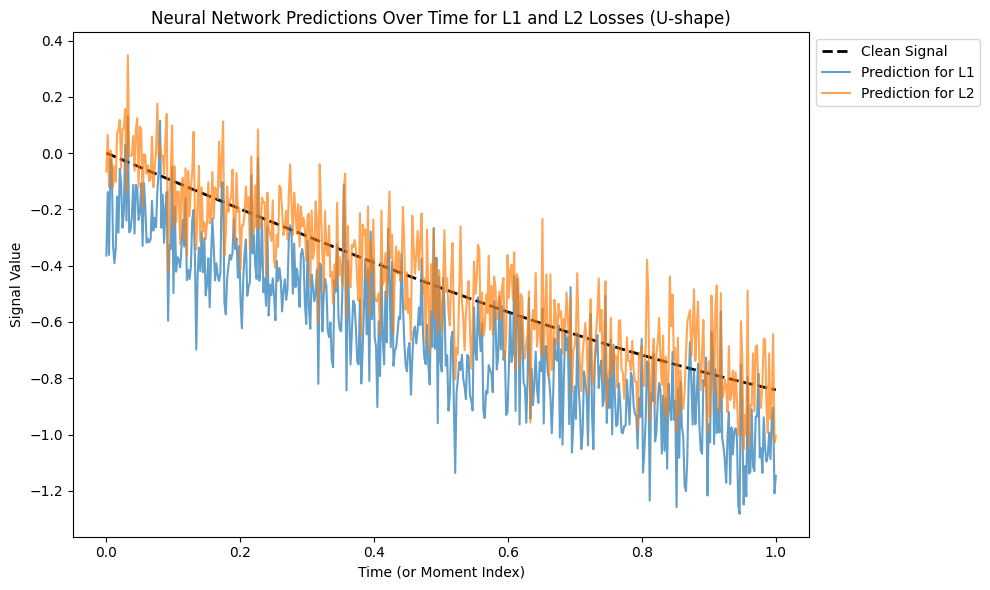

Observed Mean Difference:  0.1942
Theoretical Difference:  0.21070274431986852


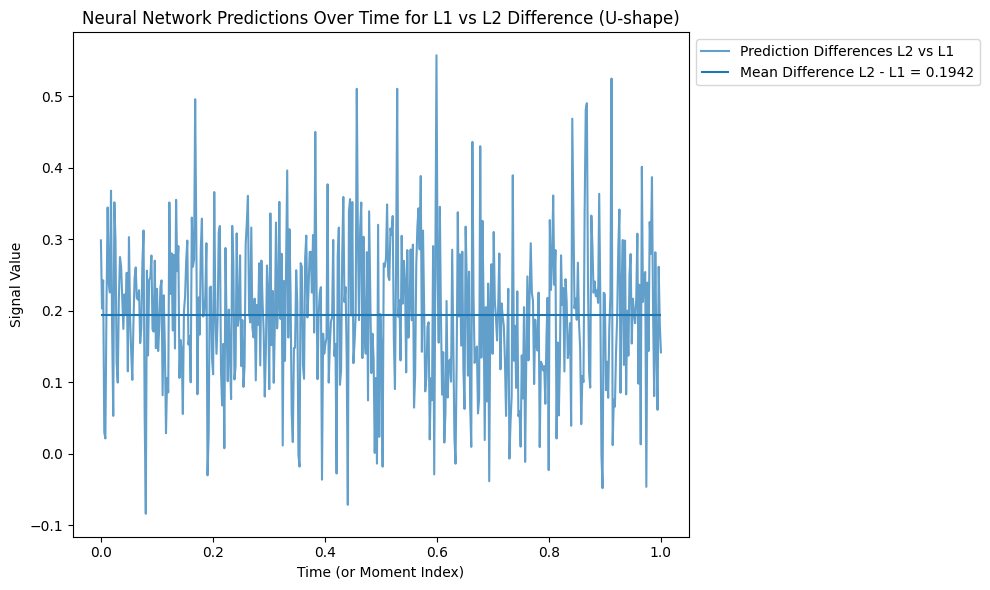

Training model for: Inverted U
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


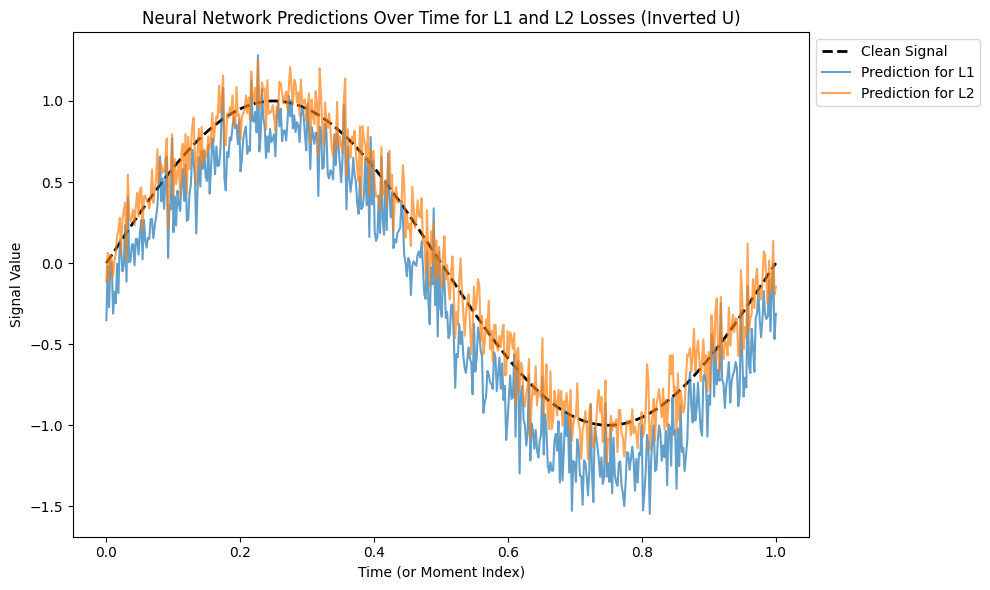

Observed Mean Difference:  0.2231
Theoretical Difference:  0.21070274431986852


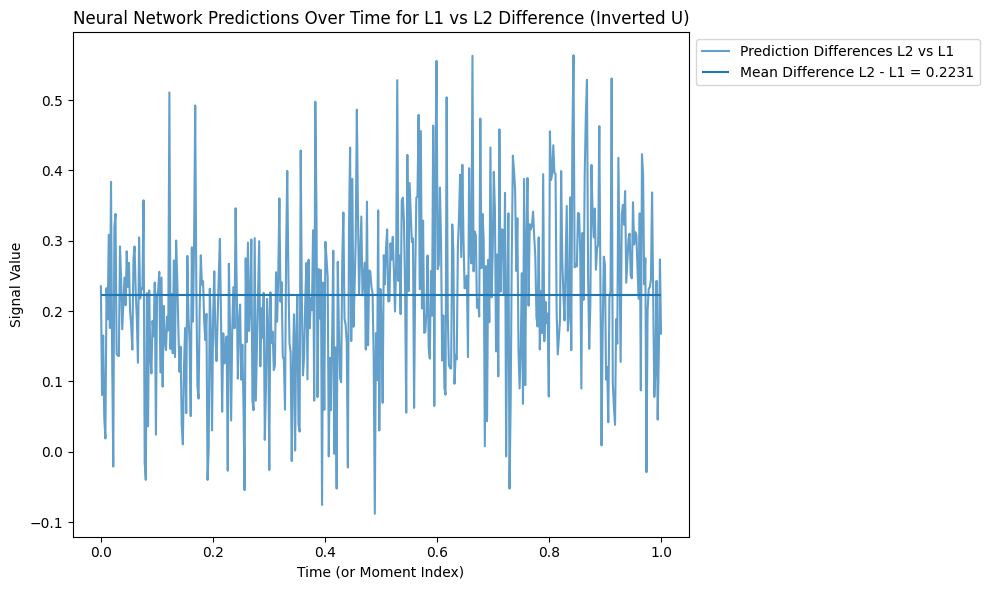

Training model for: Half U
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


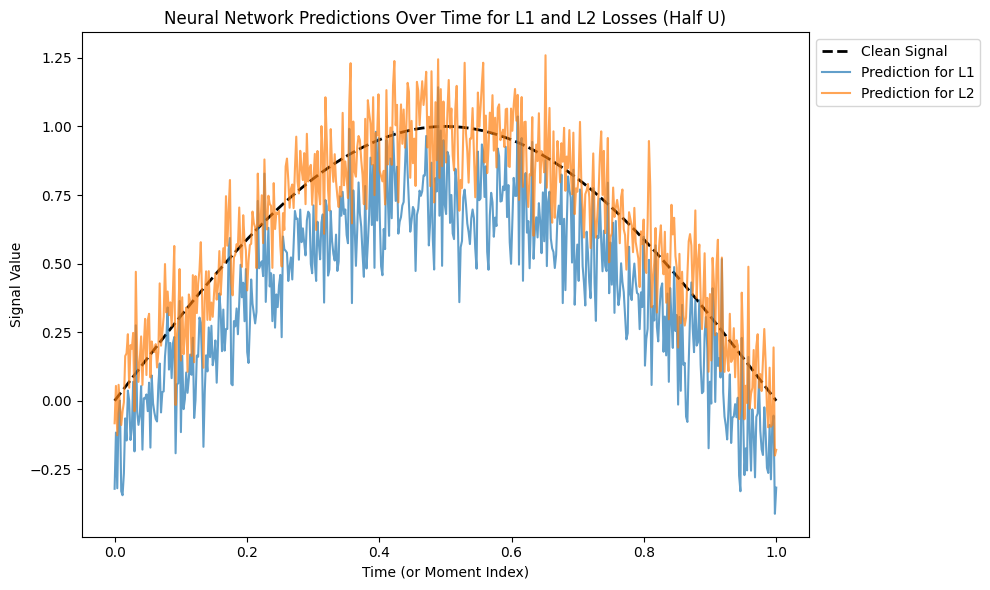

Observed Mean Difference:  0.2321
Theoretical Difference:  0.21070274431986852


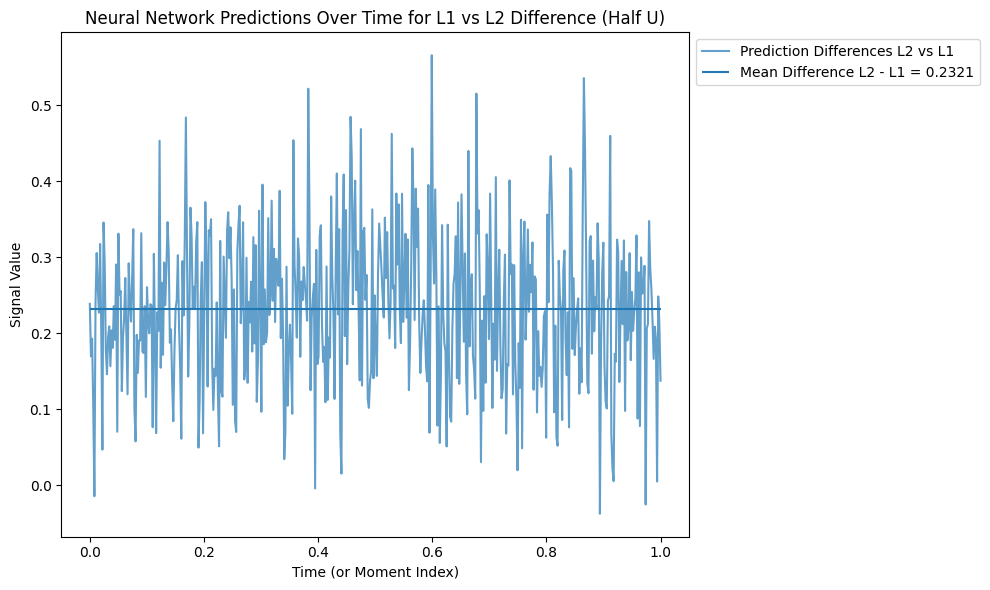

In [8]:
# Seed
seed = 3254
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Loss functions dictionary
loss_functions = {
    "L1": "mae",
    "L2": "mse",
    "Huber": keras.losses.Huber(delta=0.5)
}

# NN and series specifications
seq_length = 500   # number of time steps (moments)
num_examples = 100  # number of examples (noise realizations)
batch_size = 16
epochs = 250
learning_rate = 0.01
x = np.linspace(0, 1, seq_length)

# Different sine wave variations
y_clean_dict = {
    "U-shape": np.sin(x + 3*np.pi),  # Original
    "Inverted U": np.sin(2 * np.pi * x),  # One full oscillation
    "Half U": np.sin(np.pi * x)  # Half oscillation
}

# Noise parameters
loc = 0
scale = 1  # Controlling noise level
theory_mean = scale * np.euler_gamma
theory_median = scale * np.log(np.log(2))

mean_array = np.array([theory_mean] * (num_examples * seq_length)).reshape(num_examples, seq_length)
median_array = np.array([theory_median] * (num_examples * seq_length)).reshape(num_examples, seq_length)

for shape, y_clean in y_clean_dict.items():
    print(f"Training model for: {shape}")
    
    # Create arrays
    x_repeated = np.tile(x, (num_examples, 1))
    np.random.seed(32)
    noise = np.random.gumbel(loc=loc, scale=scale, size=num_examples * seq_length).reshape(num_examples, seq_length)
    data = np.tile(y_clean, (num_examples, 1)) + noise - mean_array
    target = np.tile(y_clean, (num_examples, 1))

    # Create and estimate models
    model = keras.models.Sequential([
        keras.layers.Input(shape=(seq_length,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(seq_length, activation='linear')
    ])

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    predict = {}

    for title, selected_loss in loss_functions.items():
        model.compile(optimizer=optimizer, loss=selected_loss)
        model.fit(x=x_repeated, y=data, batch_size=batch_size, epochs=epochs, verbose=0)
        predictions = model.predict(x_repeated)
        predict[title] = predictions[0]
    
    # Plot results for L1 and L2 losses
    plt.figure(figsize=(10, 6))
    plt.plot(x, y_clean, 'k--', linewidth=2, label='Clean Signal')
    plt.plot(x, predict["L1"], label=f'Prediction for L1', alpha=0.7)
    plt.plot(x, predict["L2"], label=f'Prediction for L2', alpha=0.7)
    plt.xlabel("Time (or Moment Index)")
    plt.ylabel("Signal Value")
    plt.title(f"Neural Network Predictions Over Time for L1 and L2 Losses ({shape})")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

    # Compute and plot difference between L2 and L1 predictions
    diff_series = np.array(predict["L2"] - predict["L1"])
    diff_mean = np.mean(predict["L2"] - predict["L1"])
    mean_rounded = str(round(diff_mean, 4))
    theoretical_diff = scale * (np.euler_gamma + np.log(np.log(2)))

    print("Observed Mean Difference: ", mean_rounded)
    print("Theoretical Difference: ", theoretical_diff)

    plt.figure(figsize=(10, 6))
    plt.plot(x, diff_series, label=f'Prediction Differences L2 vs L1', alpha=0.7)
    plt.hlines(y=diff_mean, label=f'Mean Difference L2 - L1 = {mean_rounded}', xmin=0, xmax=1)
    plt.xlabel("Time (or Moment Index)")
    plt.ylabel("Signal Value")
    plt.title(f"Neural Network Predictions Over Time for L1 vs L2 Difference ({shape})")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

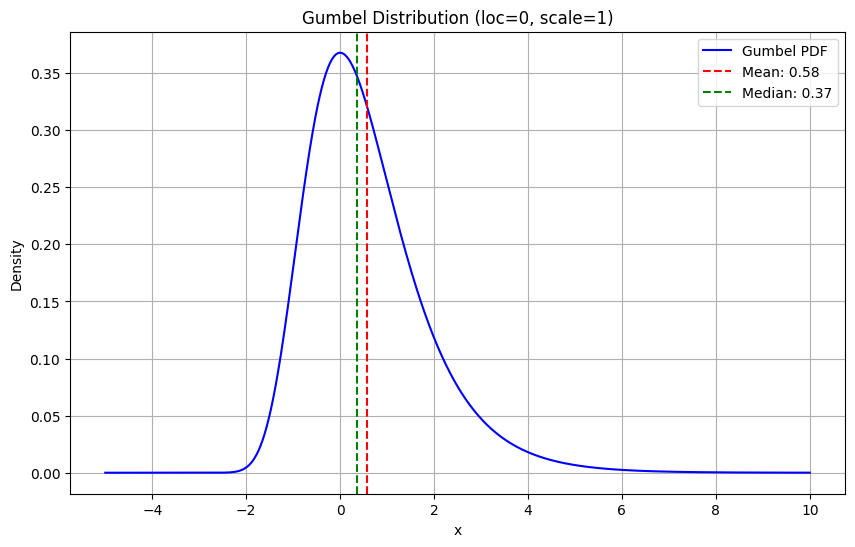

In [9]:
x_pdf = np.linspace(-5, 10, 1000)
pdf = gumbel_r.pdf(x_pdf, loc=loc, scale=scale)
mean_gumbel = gumbel_r.mean(loc=loc, scale=scale)
median_gumbel = gumbel_r.median(loc=loc, scale=scale)

plt.figure(figsize=(10, 6))
plt.plot(x_pdf, pdf, label='Gumbel PDF', color='blue')
plt.axvline(mean_gumbel, color='red', linestyle='--', label=f'Mean: {mean_gumbel:.2f}')
plt.axvline(median_gumbel, color='green', linestyle='--', label=f'Median: {median_gumbel:.2f}')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Gumbel Distribution (loc=0, scale=1)')
plt.legend()
plt.grid(True)
plt.show()

### Log-normal

Expected Value: $E(X)=\exp(\mu+\sigma^2/2)$

Median Value: $q^{0.5}_X = \exp(\mu)$

Difference: $E(X)-q^{0.5}_X = \exp(\mu+\sigma^2/2)-\exp(\mu) = \exp(\mu)(\exp(\sigma^2/2)-1) \approx 0.35914$ for $\mu=0,\sigma=1$

Training model for: U-shape
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


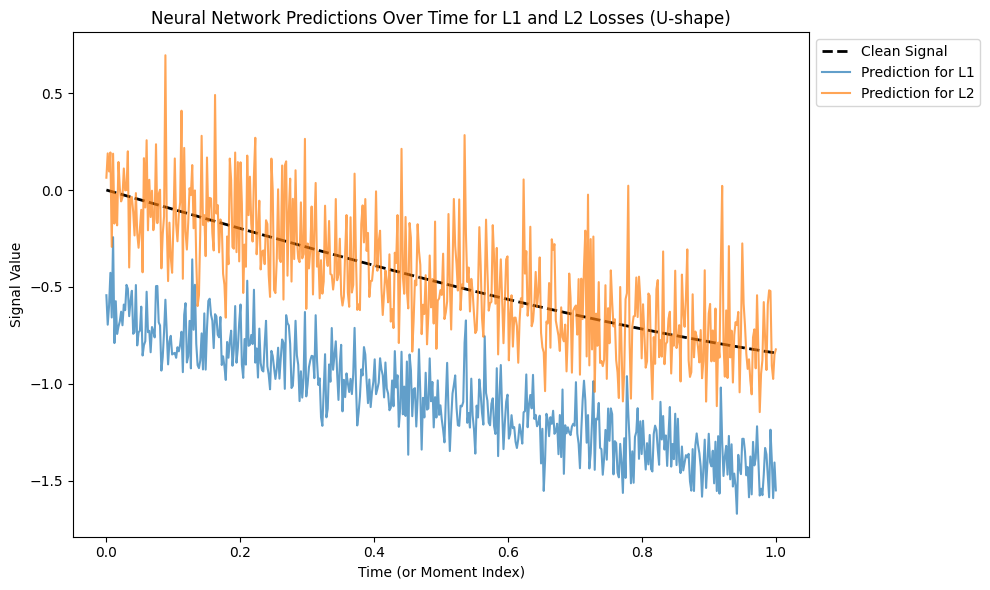

Observed Mean Difference:  0.6201
Theoretical Difference:  0.6487212707001282


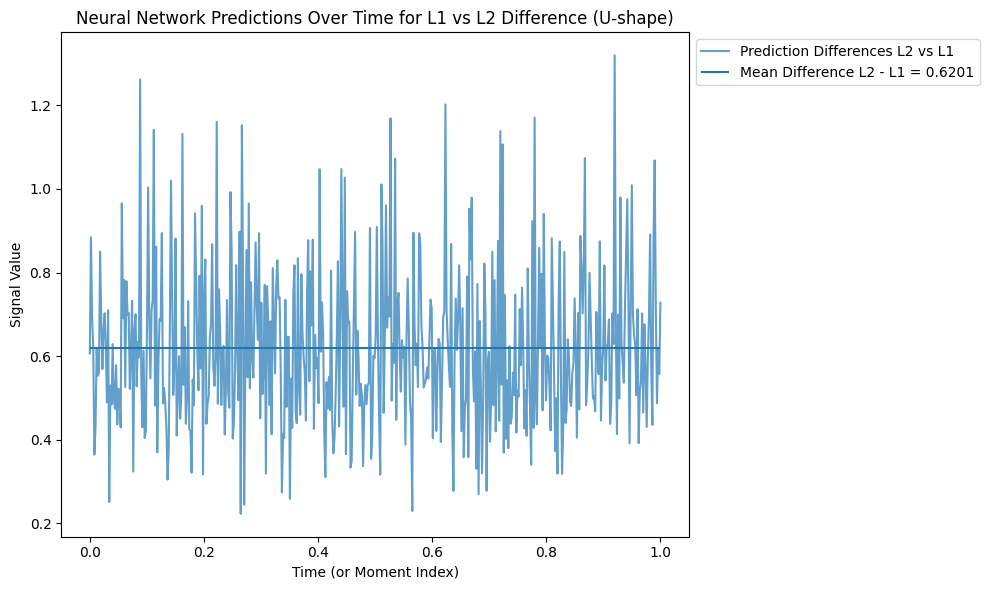

Training model for: Inverted U
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


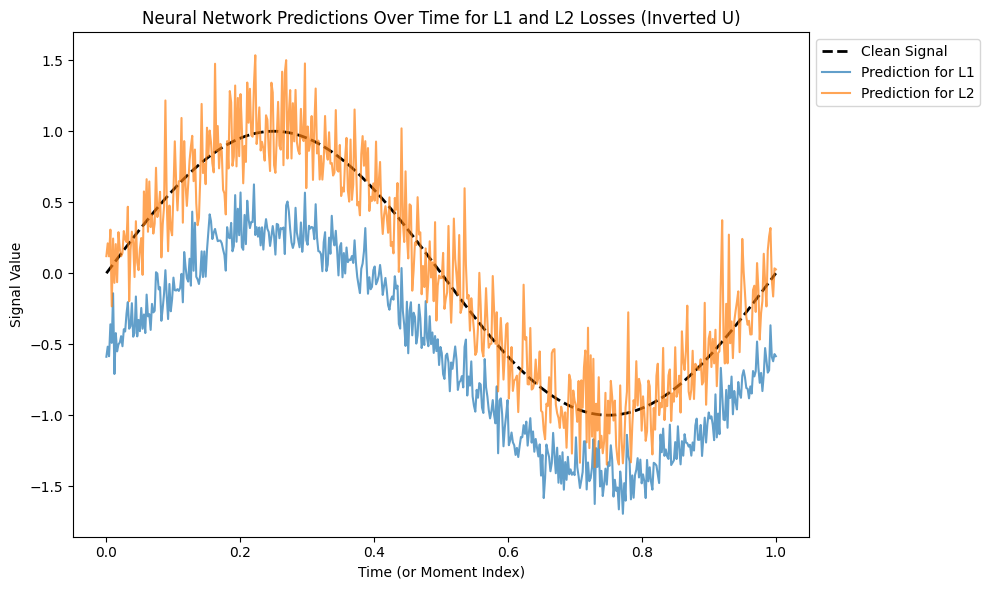

Observed Mean Difference:  0.5697
Theoretical Difference:  0.6487212707001282


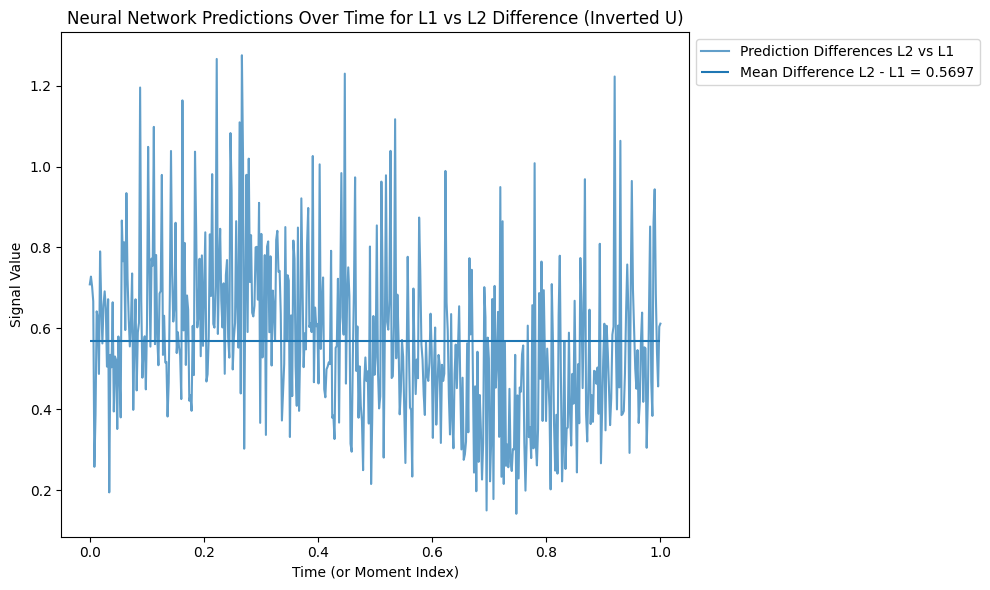

Training model for: Half U
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


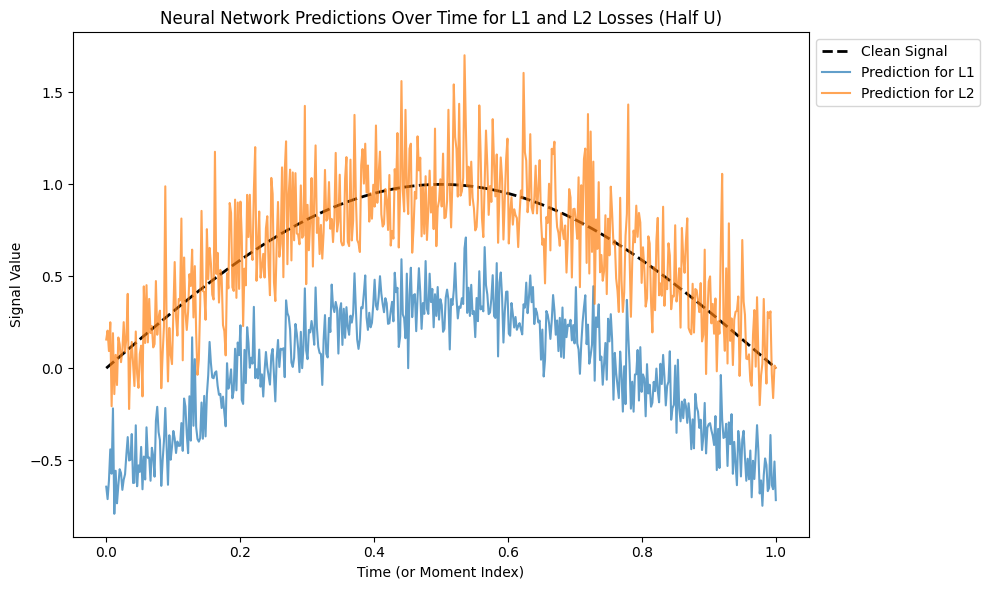

Observed Mean Difference:  0.6488
Theoretical Difference:  0.6487212707001282


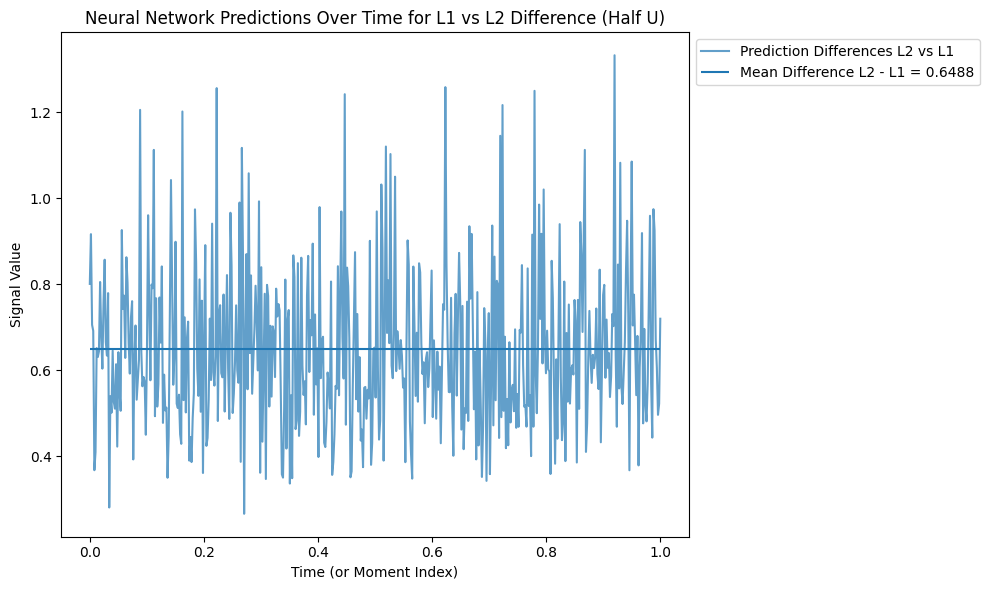

In [10]:
# Seed
seed = 3254
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Loss functions dictionary
loss_functions = {
    "L1": "mae",
    "L2": "mse",
    "Huber": keras.losses.Huber(delta=0.5)
}

# NN and series specifications
seq_length = 500   # number of time steps (moments)
num_examples = 100  # number of examples (noise realizations)
batch_size = 16
epochs = 250
learning_rate = 0.01
x = np.linspace(0, 1, seq_length)

# Different sine wave variations
y_clean_dict = {
    "U-shape": np.sin(x + 3*np.pi),  # Original
    "Inverted U": np.sin(2 * np.pi * x),  # One full oscillation
    "Half U": np.sin(np.pi * x)  # Half oscillation
}

# Noise parameters
mean=0
sigma=1  # for lower values, results vary more or less randomly, but with high values it seems to be near the expected
theory_mean = np.exp(mean+(sigma**2)/2)
theory_median = np.exp(mean)

mean_array = np.array([theory_mean] * (num_examples * seq_length)).reshape(num_examples, seq_length)
median_array = np.array([theory_median] * (num_examples * seq_length)).reshape(num_examples, seq_length)

for shape, y_clean in y_clean_dict.items():
    print(f"Training model for: {shape}")
    
    # Create arrays
    x_repeated = np.tile(x, (num_examples, 1))
    np.random.seed(32)
    noise = np.random.lognormal(mean=mean, sigma=sigma, size=num_examples * seq_length).reshape(num_examples, seq_length)
    data = np.tile(y_clean, (num_examples, 1)) + noise - mean_array
    target = np.tile(y_clean, (num_examples, 1))

    # Create and estimate models
    model = keras.models.Sequential([
        keras.layers.Input(shape=(seq_length,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(seq_length, activation='linear')
    ])

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    predict = {}

    for title, selected_loss in loss_functions.items():
        model.compile(optimizer=optimizer, loss=selected_loss)
        model.fit(x=x_repeated, y=data, batch_size=batch_size, epochs=epochs, verbose=0)
        predictions = model.predict(x_repeated)
        predict[title] = predictions[0]
    
    # Plot results for L1 and L2 losses
    plt.figure(figsize=(10, 6))
    plt.plot(x, y_clean, 'k--', linewidth=2, label='Clean Signal')
    plt.plot(x, predict["L1"], label=f'Prediction for L1', alpha=0.7)
    plt.plot(x, predict["L2"], label=f'Prediction for L2', alpha=0.7)
    plt.xlabel("Time (or Moment Index)")
    plt.ylabel("Signal Value")
    plt.title(f"Neural Network Predictions Over Time for L1 and L2 Losses ({shape})")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

    # Compute and plot difference between L2 and L1 predictions
    diff_series = np.array(predict["L2"]-predict["L1"])
    diff_mean = np.mean(predict["L2"]-predict["L1"])
    mean_rounded = str(round(diff_mean,4))
    theoretical_diff = theory_mean-np.exp(mean)

    print("Observed Mean Difference: ", mean_rounded)
    print("Theoretical Difference: ", theoretical_diff)

    plt.figure(figsize=(10, 6))
    plt.plot(x, diff_series, label=f'Prediction Differences L2 vs L1', alpha=0.7)
    plt.hlines(y=diff_mean, label=f'Mean Difference L2 - L1 = {mean_rounded}', xmin=0, xmax=1)
    plt.xlabel("Time (or Moment Index)")
    plt.ylabel("Signal Value")
    plt.title(f"Neural Network Predictions Over Time for L1 vs L2 Difference ({shape})")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

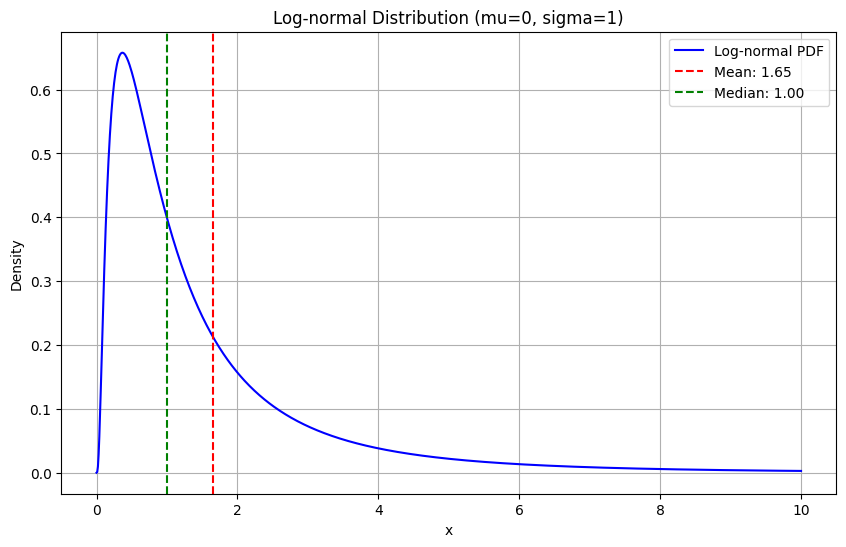

In [11]:
x_pdf = np.linspace(0, 10, 1000)
pdf = lognorm.pdf(x_pdf, s=sigma, scale=np.exp(mean))
mean_lognorm = lognorm.mean(s=sigma, scale=np.exp(mean))
median_lognorm = lognorm.median(s=sigma, scale=np.exp(mean))

# Plot the PDF
plt.figure(figsize=(10, 6))
plt.plot(x_pdf, pdf, label='Log-normal PDF', color='blue')
plt.axvline(mean_lognorm, color='red', linestyle='--', label=f'Mean: {mean_lognorm:.2f}')
plt.axvline(median_lognorm, color='green', linestyle='--', label=f'Median: {median_lognorm:.2f}')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Log-normal Distribution (mu=0, sigma=1)')
plt.legend()
plt.grid(True)
plt.show()

### Cauchy

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


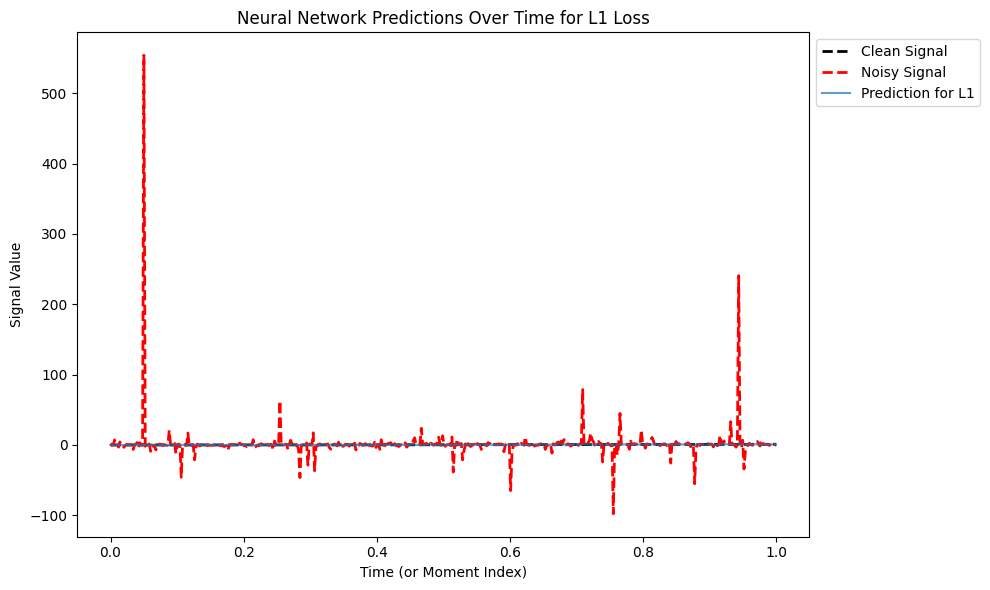

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


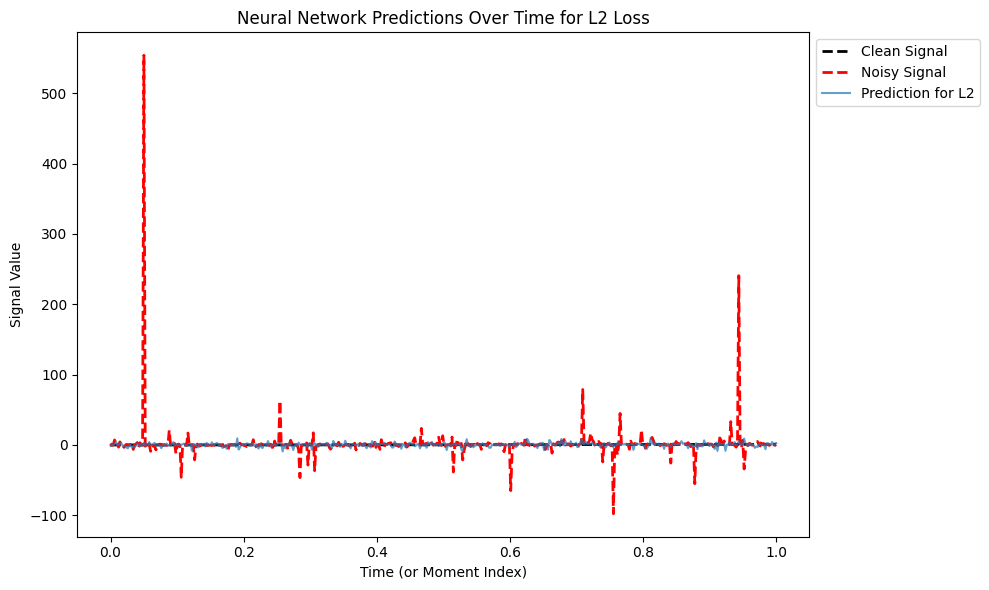

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


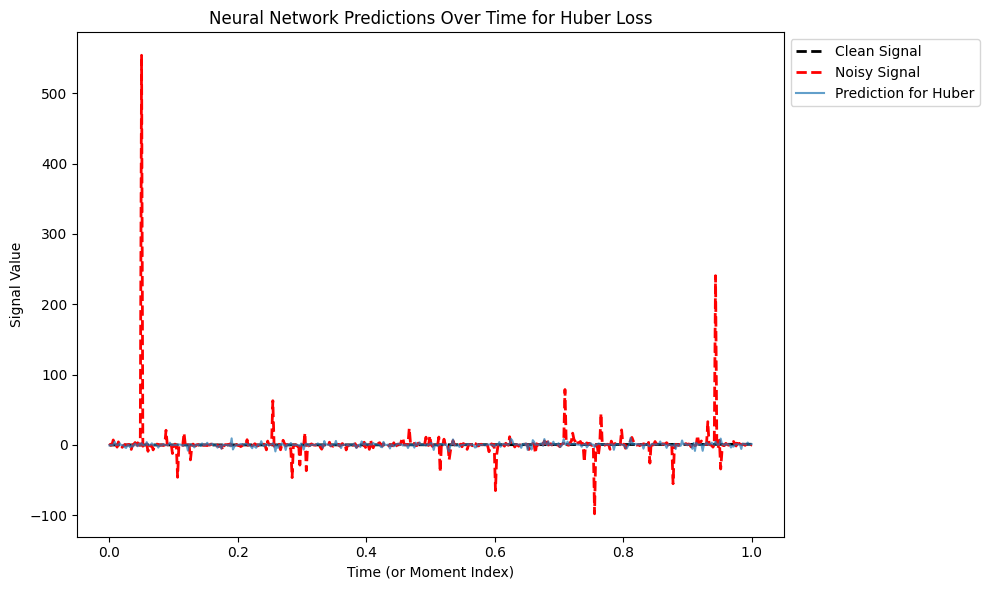

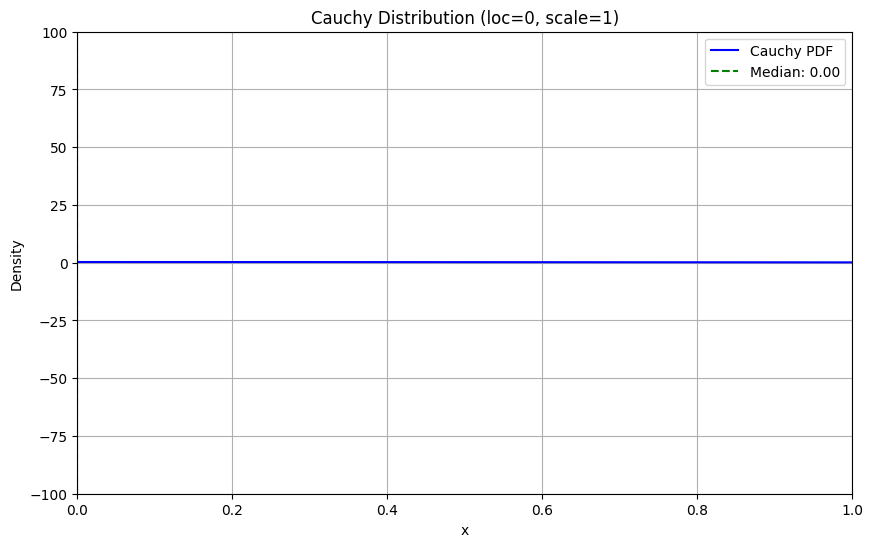

Observed Mean Difference:  -0.1477


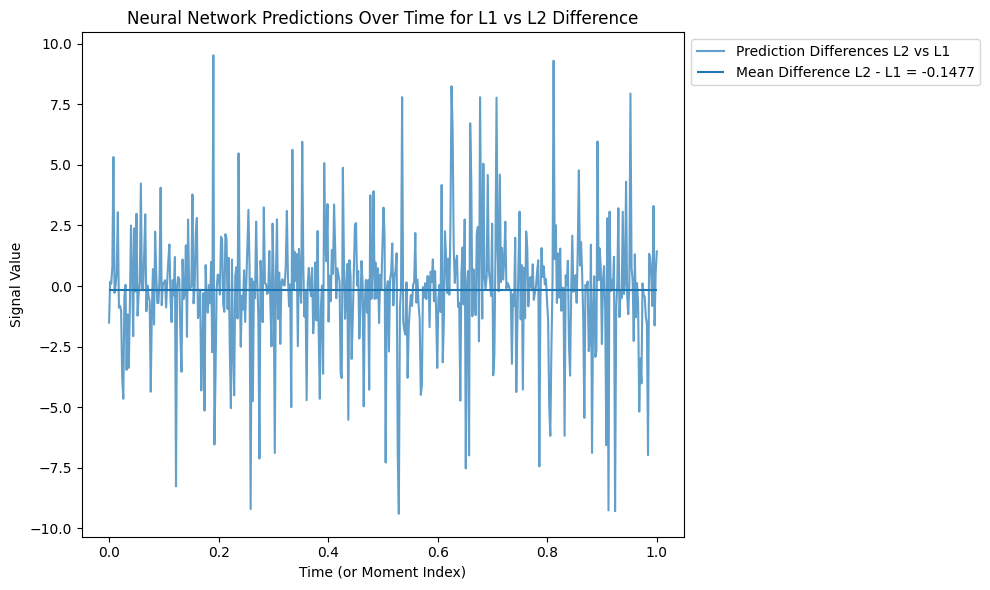

In [12]:
# Seed
seed = 3254
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Loss functions dictionary
loss_functions = {
    "L1": "mae",
    "L2": "mse",
    "Huber": keras.losses.Huber(delta=0.5)
}

# NN and series specifications
seq_length = 500   # number of time steps (moments)
num_examples = 100  # number of examples (noise realizations)
batch_size = 16
epochs = 250
learning_rate = 0.01
x = np.linspace(0, 1, seq_length)
y_clean = x**2

# Noise parameters
loc = 0
scale = 1  # Controlling noise level

# Create arrays
x_repeated = np.tile(x, (num_examples, 1))
np.random.seed(32)
noise = cauchy.rvs(loc=loc, scale=scale, size=num_examples * seq_length).reshape(num_examples, seq_length)
data = np.tile(y_clean, (num_examples, 1)) + noise
target = np.tile(y_clean, (num_examples, 1))

# Create and estimate models
model = keras.models.Sequential([
    keras.layers.Input(shape=(seq_length,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(seq_length, activation='linear')
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
predict = {}

for title, selected_loss in loss_functions.items():
    model.compile(optimizer=optimizer, loss=selected_loss)
    model.fit(x=x_repeated, y=data, batch_size=batch_size, epochs=epochs, verbose=0)
    predictions = model.predict(x_repeated)
    predict[title] = predictions[0]

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(x, y_clean, 'k--', linewidth=2, label='Clean Signal')
    plt.plot(x, data[0, :], 'r--', linewidth=2, label='Noisy Signal')
    plt.plot(x, predict[title], label=f'Prediction for {title}', alpha=0.7)
    plt.xlabel("Time (or Moment Index)")
    plt.ylabel("Signal Value")
    plt.title(f"Neural Network Predictions Over Time for {title} Loss")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

# Plot Cauchy Distribution PDF
x_pdf = np.linspace(-5, 10, 1000)
pdf = cauchy.pdf(x_pdf, loc=loc, scale=scale)
median_cauchy = cauchy.median(loc=loc, scale=scale)

plt.figure(figsize=(10, 6))
plt.plot(x_pdf, pdf, label='Cauchy PDF', color='blue')
plt.axvline(median_cauchy, color='green', linestyle='--', label=f'Median: {median_cauchy:.2f}')
plt.xlabel('x')
plt.xlim(0,1)
plt.ylabel('Density')
plt.ylim(-100,100)
plt.title('Cauchy Distribution (loc=0, scale=1)')
plt.legend()
plt.grid(True)
plt.show()

# Compute and plot difference between L2 and L1 predictions
diff_series = np.array(predict["L2"] - predict["L1"])
diff_mean = np.mean(diff_series)
mean_rounded = str(round(diff_mean, 4))

print("Observed Mean Difference: ", mean_rounded)

plt.figure(figsize=(10, 6))
plt.plot(x, diff_series, label=f'Prediction Differences L2 vs L1', alpha=0.7)
plt.hlines(y=diff_mean, label=f'Mean Difference L2 - L1 = {mean_rounded}', xmin=0, xmax=1)
plt.xlabel("Time (or Moment Index)")
plt.ylabel("Signal Value")
plt.title("Neural Network Predictions Over Time for L1 vs L2 Difference")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

### Financial Time Series

In [ ]:
# Seed
seed = 3254
np.random.seed(seed)
tf.random.set_seed(seed)
tf.data.experimental.enable_debug_mode()

# Loss functions dictionary
loss_functions = {
    "L1": "mae",
    "L2": "mse",
    "Huber": keras.losses.Huber(delta=0.5)
}

# Fetch historical stock data for Apple (AAPL)
ticker = 'AAPL'
data = yf.download(ticker, start='2020-01-01', end='2025-01-01')
if data.empty:
    raise ValueError("No data downloaded. Please check the ticker, date range, or your internet connection.")

stock_prices = data['Close'].values

# Normalize stock prices
stock_prices = (stock_prices - np.mean(stock_prices)) / np.std(stock_prices)

# Define sequence length
seq_length = 50

# Prepare input sequences and corresponding targets
X = []
y = []

for i in range(len(stock_prices) - seq_length):
    X.append(stock_prices[i:i + seq_length])
    y.append(stock_prices[i + seq_length])

X = np.array(X)
y = np.array(y)

# Split into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split].reshape(-1, 1), y[split:].reshape(-1, 1)

# Create and estimate models
def build_model():
    model = keras.models.Sequential([
        keras.layers.Input(shape=(seq_length,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='linear')
    ])
    return model

optimizer = keras.optimizers.Adam(learning_rate=0.01)
predict = {}

for title, selected_loss in loss_functions.items():
    print(f"Training model with {title} loss function.")
    model = build_model()
    # Create a new optimizer instance for each model
    optimizer = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss=selected_loss)
    model.fit(X_train, y_train, batch_size=16, epochs=100, verbose=0)
    predictions = model.predict(X_test).flatten()
    predict[title] = predictions

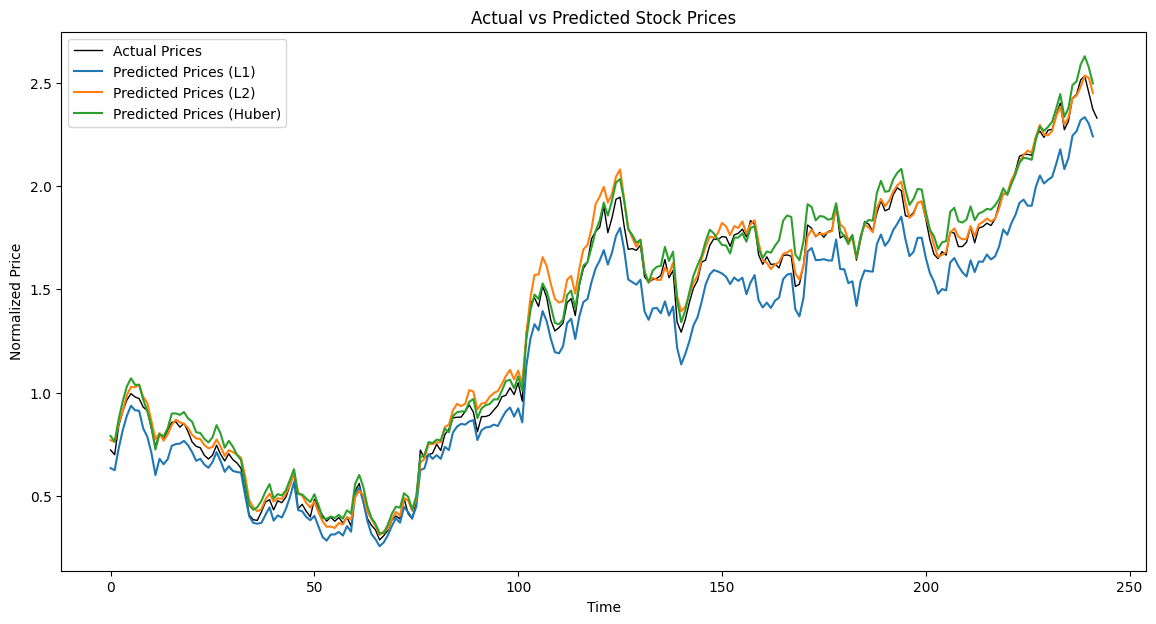

Observed Mean Difference between L2 and L1 predictions:  0.1555


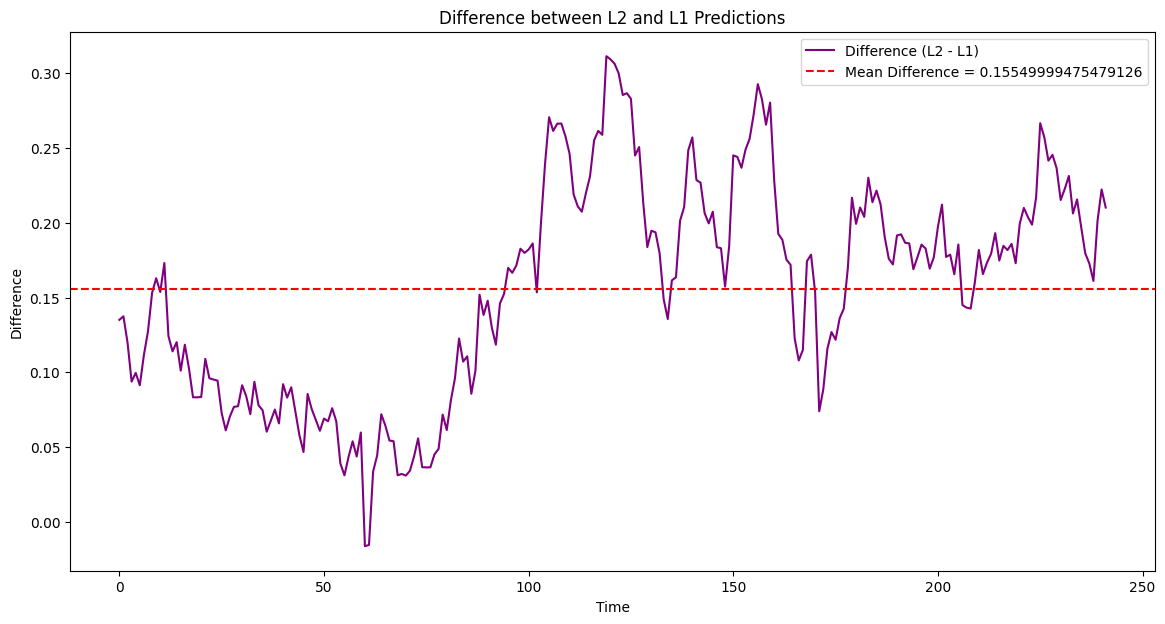

In [ ]:
# Plot actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(range(len(stock_prices[1015:])), stock_prices[1015:], label='Actual Prices', color='black', linewidth=1)
for title, predictions in predict.items():
    plt.plot(range( len(predictions)), predictions, label=f'Predicted Prices ({title})')
plt.xlabel('Time')
plt.ylabel('Normalized Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

# Compute and plot difference between L2 and L1 predictions
diff_series = predict["L2"] - predict["L1"]
diff_mean = np.mean(diff_series)
mean_rounded = round(diff_mean, 4)

print("Observed Mean Difference between L2 and L1 predictions: ", mean_rounded)

plt.figure(figsize=(14, 7))
plt.plot(range(len(diff_series)), diff_series, label='Difference (L2 - L1)', color='purple')
plt.axhline(y=diff_mean, color='red', linestyle='--', label=f'Mean Difference = {mean_rounded}')
plt.xlabel('Time')
plt.ylabel('Difference')
plt.title('Difference between L2 and L1 Predictions')
plt.legend()
plt.show()